$$\text{by Shantanu Saha, Vivek Ghelani, Koba Khitalishvili}$$

$\pagebreak$

# Tabel of Contents
  - [Intro](#Intro)
  - [Results](#Results)
  - [Appendix](#Appendix)
    - [Data](#Data)
    - [Principal Component Analysis](#Principal-Component-Analysis)
    - [Feature selection](#Feature-selection)
    - [Fitting the model](#Fitting-the-model)
      - [LogisticRegression](#LogisticRegression)
      - [XGboost](#XGboost)
      - [RandomForestClassifier](#RandomForestClassifier)
      - [ExtraTreesClassifier](#ExtraTreesClassifier)
  - [Kaggle submission](#Submission)
  - [Resources](#Resources)
  - [Authors](#Authors)
  
$\pagebreak$

# Intro

The [Santander Customer Competition](https://www.kaggle.com/c/santander-customer-satisfaction) on Kaggle provides us with a synthetic data set with 370 numerical variables. Using those variables the task is to predict whether a customer is satisfied or not. The evaluation metric is ROC AUC.

# Results

The data set contains synthetic data, i.e. it is anonymized. There were duplicate columns and columns with zero variance (standard deviation is zero) which we removed. This step reduced the number of independent variables from 370 to 308.

Using principal components analysis we can see in the [plot](#Prinicipal-Components-Analyis) (see appendix) that the two clusters of customers, satisfied and not, overlap quite a lot which makes it more difficult for the classifiers to perform well. Five principal components explain 96% percents of data (see in [appendix](#Prinicipal-Components-Analyis)). At this point we train the classifiers on the original data after performing feature selection.

For feature selection we opted for a randomized trees classifier, aka extra trees, that computes the importance coefficients of the features that are used for feature selection. We end up with 36 important features. This step reduced the number of indepent variables from 308 to 36. We use the 36 features to train our classifiers.

We tried different models to see which performs the best with the intent to concentrate on the promising candidates and improve them by tunning parameters through statistical analysis. We expect that gradient tree boosting implemented in `xgboost` python module will be the best model since it is an ensemble method.

At the end the `xgboost` classifier performed the best with the ROC area under the curve of 0.838 . For comparison, the best score on [kaggle leaderboard](https://www.kaggle.com/c/santander-customer-satisfaction/leaderboard) is 0.842 as of 3/14/2016. Unfortunately, our score puts us into the top 800, so there is room for improvement.

We consider several ways to improve our model. First, perform statistical analysis to identify relationships between variables and include interaction terms in the model. Consider other ways of feature selection and dimension reduction like factor analysis. For tunning the classifier parameters we will perform k-fold cross validation. The parameters we are looking to tune for the gradient boosting classifier are alpha (the regularization term using LASSO regression method), gamma (minimum loss reduction required to make a further partition on a leaf node of the tree), and so on.

# Reproducibility
All code used to for this project is provided in the appendix. Additionaly, you can find the IPython notebook version of this write up at https://goo.gl/654D3o . The online version has helpful links.

$\pagebreak$

# Appendix
## Data
First, we read in data.

In [1]:
import pandas as pd

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [2]:
train.iloc[:,0:5].head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1
0,1,2,23,0.0,0.0
1,3,2,34,0.0,0.0
2,4,2,23,0.0,0.0
3,8,2,37,0.0,195.0
4,10,2,39,0.0,0.0


In [3]:
train.iloc[:,0:5].describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831
min,1.000000,-999999.000000,5.000000,0.000000,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000


In [4]:
# Number of rows and columns including dependent variable TARGET
train.shape

(76020, 371)

In [5]:
# clean and split data

from tpot import TPOT
from sklearn.cross_validation import train_test_split
from sklearn import linear_model, metrics
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score
import numpy as np

# remove constant columns (std = 0)
remove = []
for col in train.columns:
    if train[col].std() == 0:
        remove.append(col)

train.drop(remove, axis=1, inplace=True)
test.drop(remove, axis=1, inplace=True)

# remove duplicated columns
remove = []
cols = train.columns
for i in range(len(cols)-1):
    v = train[cols[i]].values
    for j in range(i+1,len(cols)):
        if np.array_equal(v,train[cols[j]].values):
            remove.append(cols[j])

train.drop(remove, axis=1, inplace=True)
test.drop(remove, axis=1, inplace=True)

# split data into train and test
test_id = test.ID
test = test.drop(["ID"],axis=1)

X = train.drop(["TARGET","ID"],axis=1)
y = train.TARGET.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Principal Component Analysis

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

pca = PCA(n_components=None)
pca.fit(X_train)

pc = pd.DataFrame(pca.explained_variance_ratio_,columns=['Proportion'])
pc["Cumulative"] = [np.sum(pca.explained_variance_ratio_[0:i]) for i in range(0,len(pc))]

# principal components
pc.iloc[0:9,:]

,Proportion,Cumulative
0,0.668105,0.000000
1,0.149682,0.668105
2,0.077319,0.817786
3,0.037672,0.895106
4,0.034582,0.932777
5,0.014138,0.967359
6,0.004752,0.981497
7,0.003842,0.986249
8,0.002488,0.990091


//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


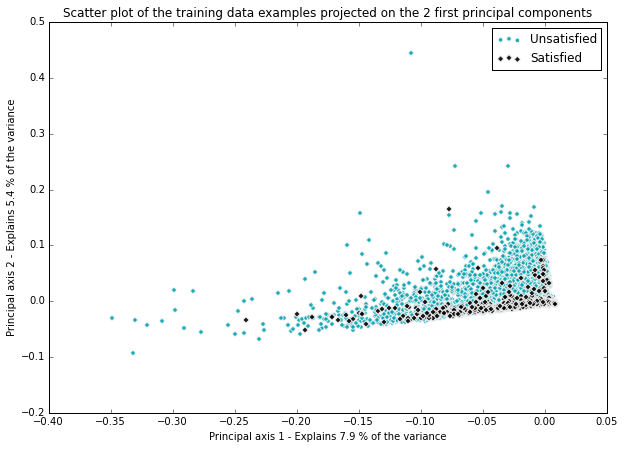

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

a = pd.DataFrame(pca.transform(X_train)).iloc[0:1000,3:5]

# normalize each feature to unit norm (vector length)
X_train_normalized = normalize(X_train, axis=0)

# project principal components onto new axis
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_projected = pca.fit_transform(X_train_normalized)

# visualize
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1)
colors = [(0.0, 0.63, 0.69), 'black']
markers = ["o", "D"]
classes = [0,1]
labels = ["Unsatisfied","Satisfied"]
for class_ix, marker, color, label in zip(
        classes, markers, colors, labels):
    ax.scatter(X_train_projected[np.where(y_train == class_ix), 0],
               X_train_projected[np.where(y_train == class_ix), 1],
               marker=marker, color=color, edgecolor='whitesmoke',
               linewidth='1', alpha=0.9, label=label)
    ax.legend(loc='best')
plt.title(
    "Scatter plot of the training data examples projected on the "
    "2 first principal components")
plt.xlabel("Principal axis 1 - Explains %.1f %% of the variance" % (
    pca.explained_variance_ratio_[0] * 100.0))
plt.ylabel("Principal axis 2 - Explains %.1f %% of the variance" % (
    pca.explained_variance_ratio_[1] * 100.0))
plt.show()

## Feature selection

In [8]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(random_state=1729)
selector = clf.fit(X_train, y_train)
# clf.feature_importances_ 
fs = SelectFromModel(selector, prefit=True)

X_train = fs.transform(X_train)
X_test = fs.transform(X_test)
test = fs.transform(test)

print(X_train.shape, X_test.shape, test.shape)

((60816, 36), (15204, 36), (75818, 36))


## Fitting a model
### NearestNeighbour

In [9]:
from sklearn.neighbors import KNeighborsClassifier

# we create an instance of Neighbours Classifier and fit the data.
nbs = KNeighborsClassifier(n_neighbors=100)
nbs.fit(X_train, y_train)

# calculate the auc
roc_auc_score(y_test, nbs.predict_proba(X_test)[:,1], average='macro')

0.67297149478594542

### LogisticRegression

In [10]:
# Logistic classifier from sklearn
m1_log = linear_model.LogisticRegression(verbose=3, max_iter=2000, random_state=1729)
m1_log.fit(X_train, y_train)

# calculate the auc
roc_auc_score(y_test, m1_log.predict_proba(X_test)[:,1],\
              average='macro')

[LibLinear]

0.65865867588734073

### Xgboost

In [11]:
import xgboost as xgb

# logistic classifier from xgboost
m2_xgb = xgb.XGBClassifier(n_estimators=350, nthread=-1, seed=1729)
m2_xgb.fit(X_train, y_train, eval_metric="auc", verbose = False,
           eval_set=[(X_test, y_test)])

# calculate the auc score
roc_auc_score(y_test, m2_xgb.predict_proba(X_test)[:,1],
              average='macro')

0.83829721053693085

### RandomForestClassifier

In [12]:
from sklearn.ensemble import RandomForestClassifier

m3_rf = RandomForestClassifier(n_estimators=100, random_state=1729)
m3_rf.fit(X_train, y_train)

# calculate the auc score
roc_auc_score(y_test, m3_rf.predict_proba(X_test)[:,1],\
              average='macro')

0.75238688999646619

### ExtraTreesClassifier

In [13]:
# Extremely Randomized Trees
from sklearn.ensemble import ExtraTreesClassifier

m4_rf = ExtraTreesClassifier(n_estimators=400, max_depth=None, 
                             min_samples_split=1, random_state=1729)
m4_rf.fit(X_train, y_train)

# calculate the auc score
roc_auc_score(y_test, m3_rf.predict_proba(X_test)[:,1],\
              average='macro')

0.75238688999646619

# Kaggle submission

In [14]:
probs = m2_xgb.predict_proba(test)

submission = pd.DataFrame({"ID":test_id, "TARGET": probs[:,1]})
submission.to_csv("submission.csv", index=False)

$\pagebreak$

# Resources
- [Sklearn documantation](http://scikit-learn.org/stable/documentation.html)
- [Ensemble methods](http://scikit-learn.org/stable/modules/ensemble.html)
- [Grid search](http://scikit-learn.org/stable/modules/grid_search.html)
- [Scikit-learn: Machine Learning in Python](http://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html), Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
- [Model Selection: Beyond the Bayesian/Frequentist Divide Isabelle Guyon](http://www.jmlr.org/papers/volume8/cawley07a/cawley07a.pdf), Amir Saffari, Gideon Dror, Gavin Cawley; 11(Jan):61--87, 2010.

# Authors
  - [Shantanu Saha](https://www.linkedin.com/in/1saha)
  - [Vivek Ghelani](https://www.linkedin.com/in/vivekghelani) 
  - [Koba Khitalishvili](http://www.kobakhit.com/)